In [174]:
from sunpy.util import scraper
from sunpy.time import TimeRange, parse_time
import pandas as pd
import urllib
import matplotlib.pyplot as plt
from matplotlib import dates
import os
import numpy as np
import datetime
import matplotlib as mpl
mpl.rcParams['xtick.direction']= 'in'
mpl.rcParams['ytick.direction']= 'in'

import seaborn as sns
sns.set_context("paper")

## Get the VLF data for transmitter of choice

In [3]:
vlf_pattern = "https://vlf.ap.dias.ie/data/birr/%Y/%m/%d/csv/Birr_{transmitter}_%Y-%m-%d_000000.csv"
vlf_scraper = scraper.Scraper(vlf_pattern, transmitter="DHO38")
files = vlf_scraper.filelist(TimeRange("2021-02-04", "2021-02-04"))
print(files)

['https://vlf.ap.dias.ie/data/birr/2021/02/04/csv/Birr_DHO38_2021-02-04_000000.csv']


In [4]:
# check if the file is already downloaded, and if not download
if not os.path.exists(files[0].split('/')[-1]):
    urllib.request.urlretrieve(files[0], files[0].split('/')[-1])

In [5]:
def read_vlf_data(file):
    """
    Read VLF csv files and return a pandas Series
    """
    aa = pd.read_csv(file, comment="#", names=["date", "data"])
    sid = pd.Series(aa["data"].values, index=pd.to_datetime(aa["date"]))
    return sid

sid = read_vlf_data(files[0].split('/')[-1])

In [6]:
def get_recent_goes():
    """
    Pull the most recent GOES X-ray data from the NOAA page
    
    Returns the GOES short and long channels as pandas series
    """
    data = pd.read_json("https://services.swpc.noaa.gov/json/goes/primary/xrays-7-day.json")
    data_short = data[data["energy"]=="0.05-0.4nm"]
    data_long = data[data["energy"]=="0.1-0.8nm"]
    time_array = [parse_time(x).datetime for x in data_short['time_tag'].values]

    gl = pd.Series(data_long["flux"].values, index=time_array)
    gs = pd.Series(data_short["flux"].values, index=time_array)
    return gl, gs

gl, gs = get_recent_goes()

<IPython.core.display.Javascript object>


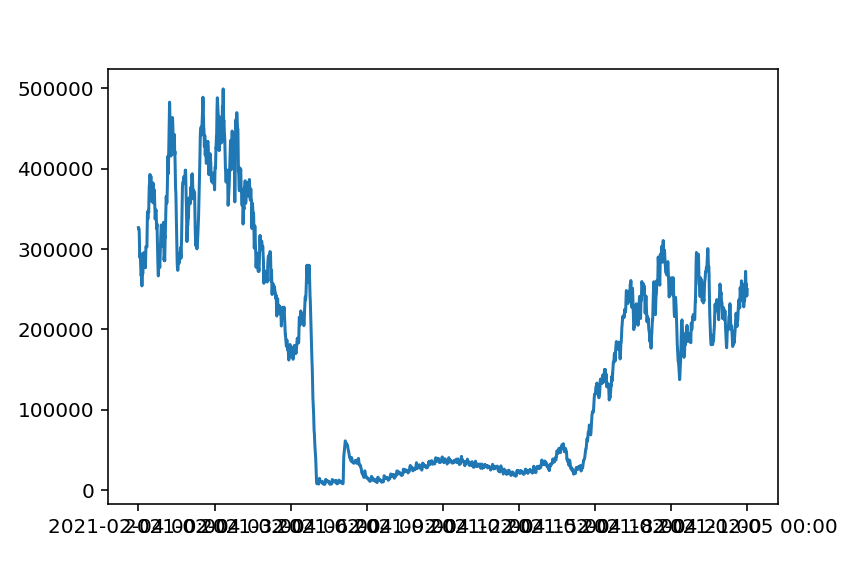

In [54]:
%matplotlib notebook
plt.plot(sid)
plt.gca().xaxis.set_major_formatter(dates.DateFormatter("%Y-%m-%d %H:%M"))

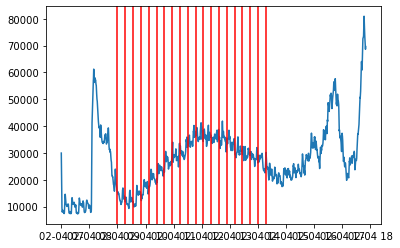

In [55]:
%matplotlib inline
plt.plot(sid.truncate("2021-02-04 07:00", "2021-02-04 17:50"))
for i in range(0, 20):
    plt.axvline(parse_time("2021-02-04 09:00").datetime+datetime.timedelta(seconds=i*1000), color="r")

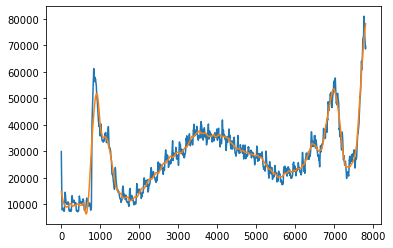

In [70]:
from scipy.signal import savgol_filter
plt.plot(np.array(sid_day ))
plt.plot(savgol_filter(sid_day,401, 3))

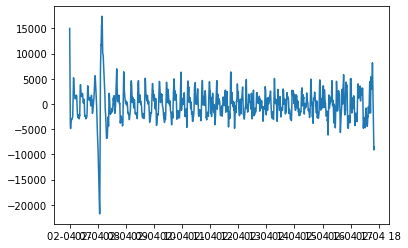

In [71]:
plt.plot(sid_day - savgol_filter(sid_day, 401, 3))

In [72]:
testy = sid_day - savgol_filter(sid_day, 401, 3)

In [131]:
sid_day = sid.truncate("2021-02-04 09:00", "2021-02-04 16:00")

/Users/laurahayes/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


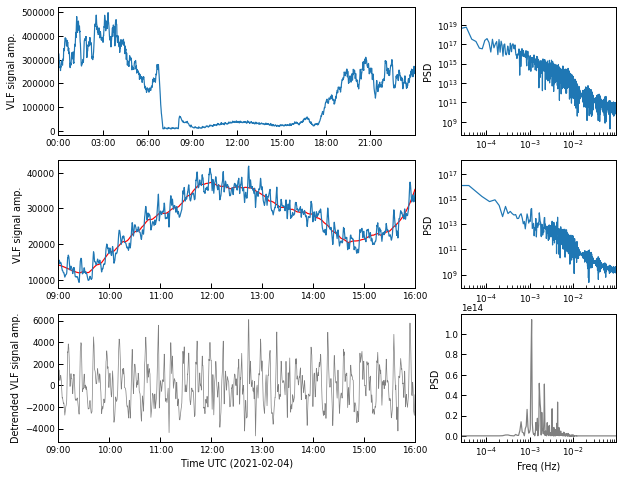

In [175]:
fig = plt.figure(constrained_layout=False, figsize=(10, 8), facecolor='w')
gs1 = fig.add_gridspec(nrows=3, ncols=3, wspace=0.3)
# gs[row, col]
ax1 = fig.add_subplot(gs1[0:1, :2])
ax2 = fig.add_subplot(gs1[1:2, :2])
ax3 = fig.add_subplot(gs1[2:3, :2])

ax4 = fig.add_subplot(gs1[0:1, 2:3])
ax5 = fig.add_subplot(gs1[1:2, 2:3], sharex=ax4)
ax6 = fig.add_subplot(gs1[2:3, 2:3], sharex=ax4)


ax1.plot(sid)
ax1.set_xlim(sid.index[0], sid.index[-1])
ax1.set_ylabel("VLF signal amp.")

ax2.plot(sid_day.index, savgol_filter(sid_day, 601, 3), color="r")
ax2.plot(sid_day)
ax2.set_xlim(sid_day.index[0], sid_day.index[-1])
ax2.set_ylabel("VLF signal amp.")

detrend_day = sid_day - savgol_filter(sid_day, 601, 3)
ax3.plot(detrend_day, color="grey", lw=0.7)
ax3.set_xlim(detrend_day.index[0], detrend_day.index[-1])
ax3.set_ylabel("Detrended VLF signal amp.")

ax1.xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
ax2.xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
ax3.xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
ax3.set_xlabel("Time UTC (2021-02-04)")

f_full, p_full = fourier_ana(np.array(sid), 5)
f_day, p_day = fourier_ana(np.array(sid_day), 5)
f_det, p_det = fourier_ana(np.array(detrend_day), 5)


ax4.loglog(f_full, p_full)
ax5.loglog(f_day, p_day)
ax6.plot(f_det, p_det, color="grey")
ax6.set_xlabel("Freq (Hz)")
for a in (ax4, ax5, ax6):
    a.set_ylabel("PSD")
ax5.set_xlim(f_full.min(), f_full.max())

plt.savefig("testy.png", dpi=200)

In [56]:
1000/60

16.666666666666668

In [58]:
sid_day = sid.truncate("2021-02-04 07:00", "2021-02-04 17:50")

In [59]:
sid.index[1:] - sid.index[:-1]

TimedeltaIndex(['0 days 00:00:05', '0 days 00:00:05', '0 days 00:00:05',
                '0 days 00:00:05', '0 days 00:00:05', '0 days 00:00:05',
                '0 days 00:00:05', '0 days 00:00:05', '0 days 00:00:05',
                '0 days 00:00:05',
                ...
                '0 days 00:00:05', '0 days 00:00:05', '0 days 00:00:05',
                '0 days 00:00:05', '0 days 00:00:05', '0 days 00:00:05',
                '0 days 00:00:05', '0 days 00:00:05', '0 days 00:00:05',
                '0 days 00:00:05'],
               dtype='timedelta64[ns]', name='date', length=17279, freq=None)

In [60]:
from scipy import fftpack
def fourier_ana(x, dt):
	N = len(x)
# 	x = x*np.hanning(N)
	dt = dt
	df = 1./(N*dt)
	PSD = abs(dt*fftpack.fft(x)[:int(N/2)])**2

	f = df*np.arange(N/2)
	if len(PSD) != len(f):
		PSD = abs(dt*fftpack.fft(x)[:int(N/2) + 1])**2
	return f, PSD

In [73]:
f, p = fourier_ana(np.array(testy),5 )

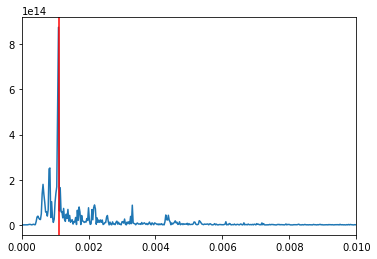

In [84]:
plt.plot(f, p)
# plt.yscale("log")
# plt.xscale("log")
# plt.xlim(0, 4000)
plt.xlim(0, 0.01)
plt.axvline(1./900, color="r")

In [87]:
from astropy import units as u
peak = (1./900)*u.Hz

In [92]:
peak

<Quantity 0.00111111 Hz>

In [93]:
10**-3

0.001

In [91]:
peak.to(u.mHz)

<Quantity 1.11111111 mHz>

## Make specific plots

In [54]:
tstart = parse_time("2020-11-29 12:00").datetime
tend = parse_time("2020-11-29 15:00").datetime

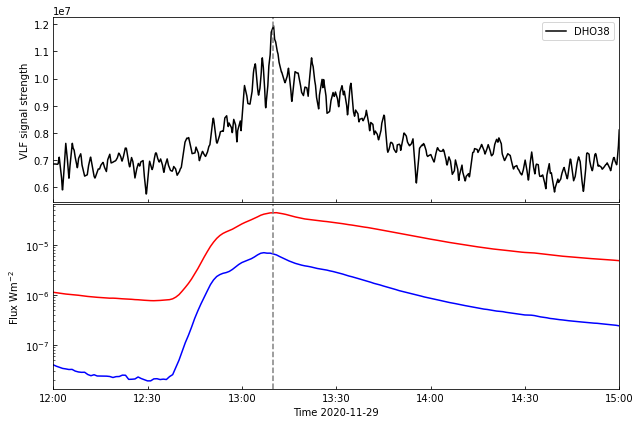

In [55]:
fig, ax = plt.subplots(2, sharex=True, figsize=(9, 6))

# plot the VLF data
ax[0].plot(sid.truncate(tstart, tend), label="DHO38", color="k")
ax[0].xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
ax[0].legend()

# plot the GOES data
ax[1].plot(gl.truncate(tstart, tend), color='r')
ax[1].plot(gs.truncate(tstart, tend), color='b')
ax[1].set_yscale("log")

for a in ax:
    a.axvline(parse_time("2020-11-29 13:10").datetime, color="grey", ls="dashed")
    #a.axvline(parse_time("2020-11-29 13:20").datetime, color="grey", ls="dashed")
    a.tick_params(which="both", direction="in")

ax[0].set_ylabel("VLF signal strength")
ax[1].set_ylabel("Flux Wm$^{-2}$")
ax[1].set_xlabel("Time 2020-11-29")

ax[1].set_xlim(tstart, tend)
ax[1].xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))

plt.tight_layout()
plt.subplots_adjust(hspace=0.01)

plt.savefig("FTA_flare_29112020.jpeg", dpi=200)


# play around with some other days

In [24]:
def get_data(tstart, tend,  transmitter="DHO38"):
    """
    Function to find and download VLF data from https://vlf.ap.dias.ie/data/
    
    Parameters
    ----------
    tstart: ~str
        start time of files to query
    tend: ~str
        end time of files to query
    transmitter: ~str
        name of transmitter
        transmitters = ["DHO38", "FTA", "JJI", "NAA", "SRC", "VTX4"]
    
    """
    vlf_pattern = "https://vlf.ap.dias.ie/data/Dunsink_{transmitter}_%Y-%m-%d_000000.csv"
    vlf_scraper = scraper.Scraper(vlf_pattern, transmitter=transmitter)
    files = vlf_scraper.filelist(TimeRange(tstart, tend))
    print(files)
    # check if the file is already downloaded, and if not download
    filenames = []
    for f in files:
        if not os.path.exists(f.split('/')[-1]):
            urllib.request.urlretrieve(f, f.split('/')[-1])
            print("downloading ..")
        if os.path.exists(f.split('/')[-1]):
            print("file found")
            filenames.append(f.split('/')[-1])
    return filenames

In [69]:
files = get_data("2020-11-03", "2020-11-05", transmitter="JJI")

['https://vlf.ap.dias.ie/data/Dunsink_JJI_2020-11-03_000000.csv', 'https://vlf.ap.dias.ie/data/Dunsink_JJI_2020-11-04_000000.csv', 'https://vlf.ap.dias.ie/data/Dunsink_JJI_2020-11-05_000000.csv']
downloading ..
file found
downloading ..
file found
downloading ..
file found


In [70]:
files

['Dunsink_JJI_2020-11-03_000000.csv',
 'Dunsink_JJI_2020-11-04_000000.csv',
 'Dunsink_JJI_2020-11-05_000000.csv']

In [71]:
sid_data = pd.concat([read_vlf_data(f) for f in files])

(18569.0, 18571.99994212963)

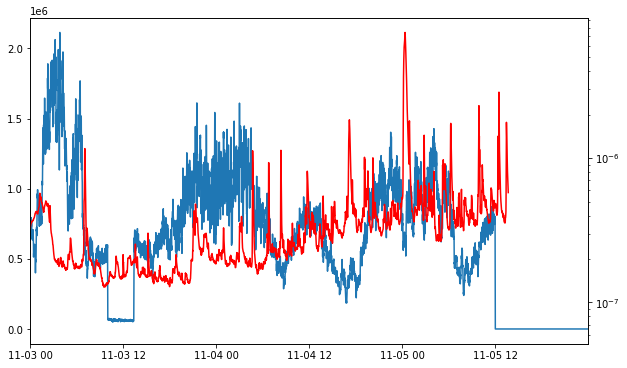

In [72]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(sid_data)

ax2 = ax.twinx()
ax2.plot(gl, color="r")
ax2.set_yscale("log")
ax.set_xlim(sid_data.index[0], sid_data.index[-1])

In [73]:
sid_day = read_vlf_data(files[1])

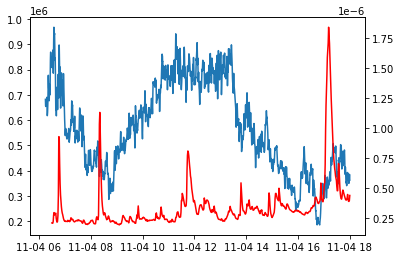

In [74]:
plt.plot(sid_day.truncate("2020-11-04 06:15", "2020-11-04 18:00"))
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(gl.truncate("2020-11-04 06:30", "2020-11-04 18:00"), color="r")